<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/pc_classification_with_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pontfelhő osztályozás többrétegú neurális hálózat (Multi-Layer Percetron) segítségével

# 1.) Pontfelhő osztályozás gépi tanulás segítségével

###Gépi tanulás vs. mély tanulás

**Mesterséges intelligencián** (AI) belül megkülönböztethetünk **gépi tanuláson** (ML), és **mély tanuláson** (DL) alapuló módszereket.

A **gépi tanulás** az AI egy részhalamza. A gépi tanuláson alapuló algoritmusok alapvetően az adathalamazokban valamilyen tulajdonság (attribútum) alapján összefüggéseket, mintázatokat keresnek, ismernek fel. Annak függvényében, hogy a minták felismerése, illetve a csoportok elkülönítése milyen módon történik megkülönböztetünk:

- *felügyelt*,
- *felügyelet nélküli*,
- *megerősített*

gépi tanulási módszereket.

A **mély tanulás** a gépi tanulási módszerek egy részhalamzába tartozik. Elsősorban egymásba ágyazott neuronhálózatok alkalmazásán alapszik. Az utóbbi időkben rohamosan fejlődő videókártyák növekvő számítási kapacitása tette lehetővé mély tanuláson alapuló a módszereknek az elterjedését.

![](https://learn.microsoft.com/hu-hu/azure/machine-learning/media/concept-deep-learning-vs-machine-learning/ai-vs-machine-learning-vs-deep-learning.png?view=azureml-api-2)




Alapvetően a gépi tanuláson és mély tanuláson alapuló módszerek között a fő különbség a következő táblázat mutatja be:


Szempontok | Gépi tanulás | Mély tanulás
 --- | --- | ----
 Adatok száma | Kisebb mennyiségű adattal operál | Nagy mennyiségű adattal operál
 Hardverigény | Nincs szükség nagy számítási kapacitásra | Nagy számítási kapacitás szükséges, elsősorban GPU
 Jellemzők (feature) meghatározása szempontjából | Felhasználónak kell kiválasztani, előkészíteni, meghatározni | Halózat magának választja ki
  Tanítás ideje | Viszonylag kevés időt vesz igénybe | Általában hosszú időt vesz igénybe
 Kimenet | A kimenet általában numerikus érték, pl.: pontszám vagy besorolás | A kimenet több formátumot is tartalmazhat, pl.: szöveget, pontszámot vagy hangot



![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/ml_vs_dl.jpg?raw=true)


### Gépi tanulás és pontfelhők

A pontfelhők esetében megkülönböztetünk geometria, spektrális és sajátértékeken alapuló jellemzőket. A geometriai jellemzők lehetnek az egyes koordináták, lokális pontsűrűség, különböző görbület értékek. Spektrális jellemzőkhöz elsősorban a különböző szín, intenzitás adatok tartozhatnak. Léteznek úgynevezett sajátértéken alapuló pontfelhő jellemzők is.

A pontfelhő egy pontjának sajátértékei ($\lambda_1$, $\lambda_2$ és $\lambda_3$) a $Q$ mátrix sajátértékei, amely a következő képlettel számítható ki:

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/kovmtx.png?raw=true)

Ahol $A$ mátrix tartalmazza az adott pont $R$ sugarú környezetében található pontok koordinátáit, a súlypont koordinátáival történő eltolása után:

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/amtx.png?raw=true)

Ezek a sajátértékek értékes információt tartalmazhatnak az adott pont és környezetébe eső pontok által alkotott ponthalmaz geometriájáról és ezekből további jellemzők vezethetőek le:

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/sajatertekek.png?raw=true)

Pontfelhők esetében a különböző gépi tanuláson alapuló algoritmusok a sajátértékekből és az ezekből levezethető egyéb tulajdonságokból indulhatnak ki.

A következőkben egy gyakorlati példán keresztül nézzük meg, hogyan használhatók fel a manuálisan meghatározott pontfelhő jellemző tető és növényzet osztályozásra egy többrétegő neurális hálózat segítségével.

## 2.) Előkészítés

### a.) Tanító adatok letöltése

Először töltsünk tanításhoz szükséges adatokat a következő Google Drive link segítségével:

In [1]:
!gdown -q --folder https://drive.google.com/drive/folders/1K6gBuQhGcJVW1Cbsa3qgVrs_x-_f17xT?usp=sharing -O PC_Classes

A letöltött mappa manuálisan szegmentált pontfelhőket tartalmaz osztályok szerint almappákba rendezve.

Első lépésként definiáljuk az ehhez kapcsolodó változókat, úgy hogy az egyes változók az egyes mappák neveit tartalmazzák!

In [6]:
DATADIR = './PC_Classes'
CATEGORIES = ['Roofs','Vegetation']

Az pontfelhő egyes [pontjainak jellemzőit (geometric features)](https://www.cloudcompare.org/doc/wiki/index.php/Compute_geometric_features) a [CloudCompare](https://www.danielgm.net/cc/) nyílt forráskodú szofver segítségével határozhatjuk meg. A szoftver segítségével hamisszínes megjelenítéssel vizualizálhatjuk a meghatározott jellemzőket, illetve exportálhatjuk is az adott pontfelhővel együtt, mint kiegészítő információ (skalármező).

 Az általunk letöltött pontfelhők a következő jellemzőket tartalmazzák:

- Omnivariancia (omnivariance)
- Anizotrópia (anisotropy)
- Síklapúság (planarity)
- Felület változás (surface variation)
- Gömbszerűség (spherecity)
- Szomszédos pontok száma (number of neighbors)
- Sűrűség (surface density)
- Normálisok irányváltozásának mértéke (normal change rate)

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/planarity.png?raw=true)

A CloudCompare az exportálásnál a skalármező neve alapján tárolja a különböző értékeket. Az előkészítés során nekünk az egyes skalármezők adatait ki kell majd keresnünk, emiatt érdemes a keresendő értékek neveit tartalmnazó listát létrehoznunk:

In [7]:
custom_extra_dim_names = ['Omnivariance__(0.3)',
                          'Anisotropy__(0.3)',
                          'Planarity__(0.3)',
                          'Surface__variation__(0.3)',
                          'Sphericity__(0.3)',
                          'Number__of__neighbors__(r_eq_0.3',
                          'Surface__density__(r_eq_0.3)',
                          'Normal__change__rate__(0.3)']

### c.) Adatok előkészítése

A jellemző értékek kikeresésére a laspy modult fogjuk használni. Telepítsük azt!

In [2]:
!pip install -q laspy
!pip install -q open3d
import laspy
import open3d as o3d
import numpy as np
import os
import shutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.5 MB/s eta 0:00:00


Telepítés után a következő függvény segítségével olvassuk be az adatokat egy Numpy tömbbe!

In [3]:
def pc_features2np(pc_las_fnm, custom_extra_dim_names):
    ''' Pontfelhő beolvasása jellemzőkkel egy numpy tömbbe.
        Paraméterek:
                    pc_las_fnm (str): fájlnév
                    custom_extra_dim_names (lista stringekkel): a kiválasztott értékek listája
        Eredmény:
                    numpy tömb a kiválasztott értékekkel
    '''
    # Pontfelhő beolvasása
    las = laspy.read(pc_las_fnm)
    extra_dim_lst = list(las.point_format.extra_dimension_names)

    # Kiválasztott jellemzők beolvasása numpy tömbbe
    pc_xyz_features = []
    list_of_features = ['x', 'y', 'z', 'r', 'g', 'b']

    for extra_dim in custom_extra_dim_names:
        if len(pc_xyz_features) == 0:
            id = [n for n, x in enumerate(extra_dim_lst) if extra_dim in x]
            pc_xyz_features = las[extra_dim_lst[id[0]]].reshape(-1,1)
        else:
            id = [n for n, x in enumerate(extra_dim_lst) if extra_dim in x]
            col = las[extra_dim_lst[id[0]]].reshape(-1,1)
            pc_xyz_features = np.concatenate([pc_xyz_features, col], axis=1)

    # XYZ és színadatok gyűjtése
    xyz = las.xyz.reshape((-1,3))
    r = (las.red // 256).astype(np.uint8).reshape((-1,1))
    g = (las.green // 256).astype(np.uint8).reshape((-1,1))
    b = (las.blue // 256).astype(np.uint8).reshape((-1,1))
    colors = np.concatenate([r, g, b], axis=1).reshape(-1,3)

    # Adatok összefűzése egy tömbbe
    if len(pc_xyz_features) == 0:
        pc_xyz_colors_features = np.concatenate([xyz, colors], axis=1)
    else:
        pc_xyz_colors_features = np.concatenate([xyz, colors, pc_xyz_features], axis=1)

    # Ellenőrzés, hogy nincs-e None adat
    pc_xyz_colors_features_filt = (pc_xyz_colors_features[~np.isnan(pc_xyz_colors_features).any(axis=1), :])

    return pc_xyz_colors_features_filt


In [8]:
# Az X_features és y_labels létrehozása tanítási adatokkal és címkékkel
X_features = []
y_labels = []

# A kategóriák mentén iterálás
for category in CATEGORIES:
    # A kategóriához tartozó elérési út összeállítása
    path = os.path.join(DATADIR, category)
    # Az osztály számának meghatározása
    class_num = CATEGORIES.index(category)
    # A fájlokon belüli iteráció
    for pc in os.listdir(path):

        # Ha még nem töltöttük fel az X_features és y_labels listákat
        if len(X_features) == 0:
            X_features = pc_features2np(os.path.join(path, pc), custom_extra_dim_names)
            y_labels = np.full(X_features.shape[0], class_num)

        else:
            # Jellemzők és címkék hozzáadása az X_features és y_labels listákhoz
            features = pc_features2np(os.path.join(path, pc), custom_extra_dim_names)
            labels = np.full(features.shape[0], class_num)
            X_features = np.concatenate((X_features, features), axis=0)
            y_labels = np.concatenate((y_labels, labels), axis=0)

# Teszt mérete - azonosnak kell lennie
print("Beolvasott pontok száma:", X_features.shape[0])
print("Az egyes pontokhoz tartozó jellemzők száma:", X_features.shape[1])

Beolvasott pontok száma: 5260210
Az egyes pontokhoz tartozó jellemzők száma: 14


Ellenőrzésként írassuk ki az egyes elemek számát címkénként:

In [9]:
unique_labels, unique_label_counts = np.unique(y_labels, return_counts=True)
for label, count in zip(unique_labels, unique_label_counts):
    print(f'Az {label}-s címkéhez tartozó elemek száma: {count}')

Az 0-s címkéhez tartozó elemek száma: 3360481
Az 1-s címkéhez tartozó elemek száma: 1899729


Normalizáljuk az adatokat a scikit-learn MinMaxScaler függvényével 0 és 1 közötti tartományra:

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Adatok szétválasztása
xyz_X_features = X_features[:,0:3]
#colors_X_features = X_features[:,3:6]

# Normalizálás
scaler = MinMaxScaler()
X_features_scaled = scaler.fit_transform(X_features[:,2:X_features.shape[1]])

In [11]:
X_features_scaled = np.concatenate((xyz_X_features[:,0:2],X_features_scaled),axis=1)

A beolvasott adatokat válasszuk szét tanító (train) teszt (test) adatokká. A következő példánál a tanításhoz a beolvasott adatok 70% használjuk majd fel.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     X_features_scaled, y_labels, test_size=0.3, shuffle=True)

Érdemes validáló (validation) adatokat is használni, amik az esetleges túl- és alultanítások feltárásában segíthetnek nekünk. Jelen esetben ez a teszt adatok harmada lesz majd.

Így a mi példánkban a beolvasott adatok 70% tanító, 20% teszt és 10% validáló adat lesz majd.

In [13]:
X_test, X_valid, y_test, y_valid = train_test_split(
     X_test, y_test, test_size=0.33, shuffle=True)

## 3.) Multi-Layer Perceptron modell előállítása és tanítása

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/ml_mlp.png?raw=true)

A modell tanítására a keras modult fogjuk felhasználni.

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools

Adjuk meg, hogy milyen névvel szeretnénk menteni, illetve hány epocháig szeretnénk tanítani a modellt!


In [15]:
model_filename = 'mlp_model.pickle'
epochs = 25 # 1000 epocháig tesztelve, elegendő 50

Hozzuk létre a többrétegű neurális hálónkat a keras segítségével, majd indítsuk el a tanítást. Ez eltarthat néhány percig...

Addig is van időnk tanulmányozni a beállított paramétereket!

In [16]:
# Modell meghatározása
mlp_model = Sequential()
mlp_model.add(Dense(units=15, activation='relu', input_dim=X_train.shape[1]-2))  # Bemeneti réteg 15 neuronnal
mlp_model.add(Dense(units=1, activation='sigmoid'))  # Kimeneti réteg 1 neuron a bináris osztályozáshoz

# Modell összeállítása
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell tanítása
mlp_model.fit(X_train[:, 2:], y_train, batch_size=1024, epochs=epochs, validation_data=(X_valid[:, 2:], y_valid), verbose=2)  # Az epochokat igény szerint állíthatja

# Modell mentése pickle segítségével
with open(model_filename, 'wb') as f:
    pickle.dump(mlp_model, f)

Epoch 1/25
3596/3596 - 17s - loss: 0.2560 - accuracy: 0.8964 - val_loss: 0.1377 - val_accuracy: 0.9529 - 17s/epoch - 5ms/step
Epoch 2/25
3596/3596 - 11s - loss: 0.1131 - accuracy: 0.9617 - val_loss: 0.1003 - val_accuracy: 0.9667 - 11s/epoch - 3ms/step
Epoch 3/25
3596/3596 - 11s - loss: 0.0951 - accuracy: 0.9679 - val_loss: 0.0925 - val_accuracy: 0.9690 - 11s/epoch - 3ms/step
Epoch 4/25
3596/3596 - 11s - loss: 0.0899 - accuracy: 0.9696 - val_loss: 0.0892 - val_accuracy: 0.9702 - 11s/epoch - 3ms/step
Epoch 5/25
3596/3596 - 10s - loss: 0.0869 - accuracy: 0.9706 - val_loss: 0.0866 - val_accuracy: 0.9717 - 10s/epoch - 3ms/step
Epoch 6/25
3596/3596 - 10s - loss: 0.0836 - accuracy: 0.9718 - val_loss: 0.0830 - val_accuracy: 0.9718 - 10s/epoch - 3ms/step
Epoch 7/25
3596/3596 - 10s - loss: 0.0806 - accuracy: 0.9727 - val_loss: 0.0802 - val_accuracy: 0.9726 - 10s/epoch - 3ms/step
Epoch 8/25
3596/3596 - 11s - loss: 0.0785 - accuracy: 0.9732 - val_loss: 0.0784 - val_accuracy: 0.9731 - 11s/epoch - 3

Nézzük meg, hogy miből áll a modell!

In [17]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                195       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 211 (844.00 Byte)
Trainable params: 211 (844.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ábrázoljuk a tanítás folyamatát!

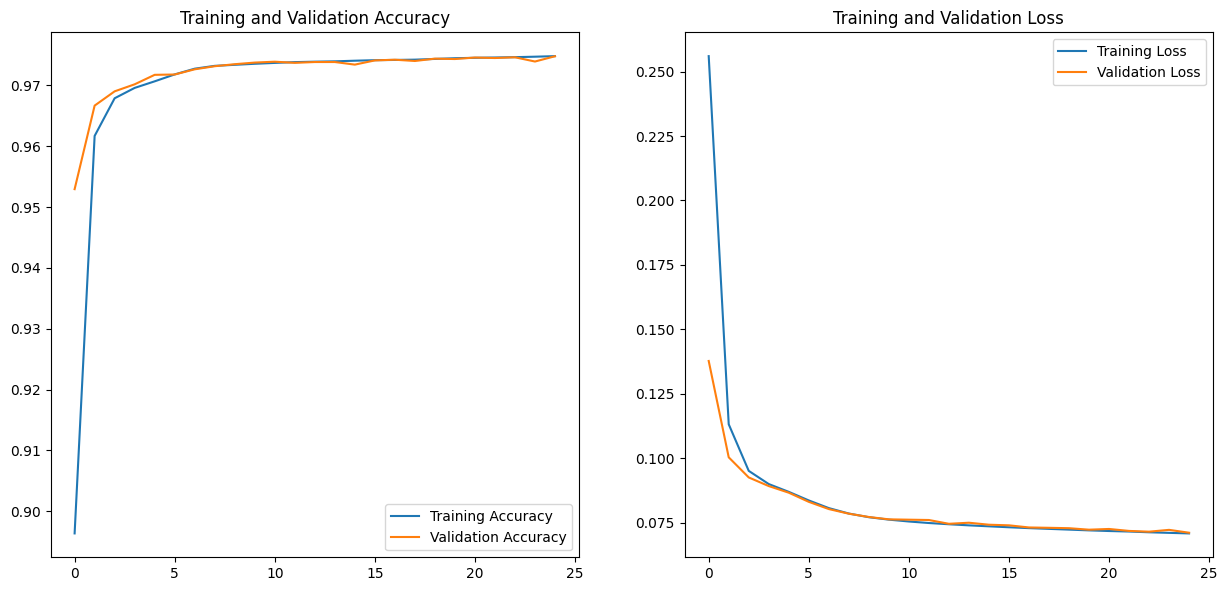

In [18]:
acc = mlp_model.history.history['accuracy']
val_acc = mlp_model.history.history['val_accuracy']
loss = mlp_model.history.history['loss']
val_loss = mlp_model.history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

A teszt adatok felhasználásával jelenítsünk meg pár metrikát!

In [19]:
# Pontossági érték kiszámítása és kiíratása
y_mlp_predictions = mlp_model.predict(X_test[:,2:X_test.shape[1]])
# Valószínűségek átalakítása osztálycímkékké a küszöbérték alapján
küszöbérték = 0.5
y_mlp_predictions = np.where(y_mlp_predictions >= küszöbérték, 1, 0)

print('Modell pontossága: {0:0.4f}'. format(accuracy_score(y_test, y_mlp_predictions)))
print("Pontosság a teszt adatokon \n",classification_report(y_test,y_mlp_predictions, target_names = CATEGORIES))


33041/33041 [==============================] - 53s 2ms/step
Modell pontossága: 0.9750
Pontosság a teszt adatokon 
               precision    recall  f1-score   support

       Roofs       0.98      0.98      0.98    675185
  Vegetation       0.96      0.97      0.97    382117

    accuracy                           0.97   1057302
   macro avg       0.97      0.97      0.97   1057302
weighted avg       0.98      0.97      0.97   1057302



Jelenítsük meg a zavar mátrixot!

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Valószínűségek átalakítása osztálycímkékké a küszöbérték alapján
threshold = 0.5
y_mlp_predictions_binary = np.where(y_mlp_predictions >= threshold, 1, 0)

# Konfúziós mátrix számítása
cm = confusion_matrix(y_test, y_mlp_predictions_binary)

In [21]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    '''
    A függvény segít ábrázolni a zavar mátrixot.
    '''
    # Pontosság és hibás osztályozás kiszámítása

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    # Alapértelmezett színskála beállítása
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    # Normalizálás
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2

    # Címkék beállítása, ha elérhetők
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    # Számok hozzáadása a cellákhoz
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(model_filename[:-7]+'_conf_mtx.svg', format='svg')
    plt.show()

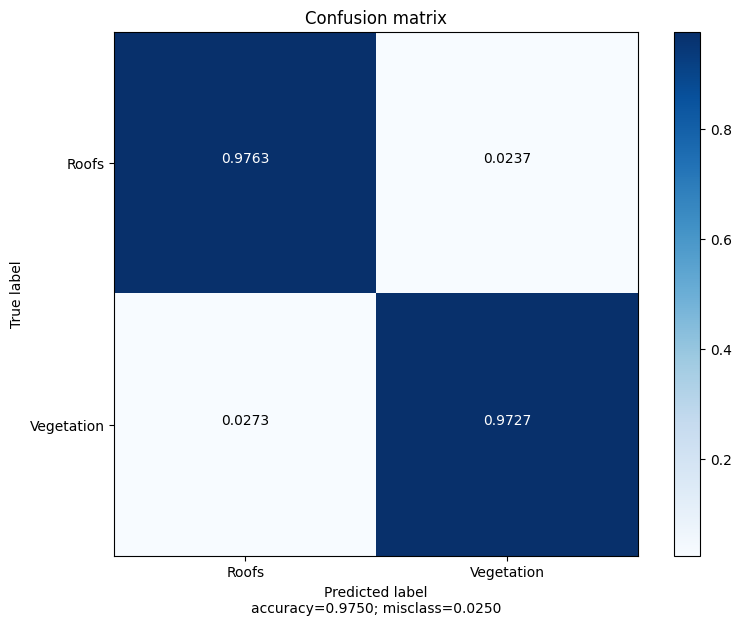

In [22]:
cm_display2 = plot_confusion_matrix(cm, target_names=CATEGORIES)

## 4.) Használjuk fel az MLP modellt egy nagyobb pontfelhőn!

Töltsük le a pontfelhőt!

In [24]:
!gdown -q --fuzzy https://drive.google.com/file/d/1c8T5TZ8HqfqaGfDo-M0DXJJk9BeV30Uw/view?usp=drive_link -O barnag_pointcloud_with_fts.las

In [25]:
# Letöltött pontfelhő jellemzőkkel
pc_fnm = 'barnag_pointcloud_with_fts.las'
# Létrehozott modell
model_filename = 'mlp_model.pickle'
# Mappa ahova mentse majd az eredményeket
new_folder = pc_fnm[:-4] + '_predicted_classes'

Előkészítés

In [26]:
pc2np = pc_features2np(pc_fnm, custom_extra_dim_names)
X_features = pc2np[:,2:pc2np.shape[1]]
X_features = MinMaxScaler().fit_transform(X_features)

Modell betöltése és alkalmazása

In [27]:
model = pickle.load(open(model_filename, 'rb'))
y_predict = model.predict(X_features)
threshold = 0.5
y_predict = np.where(y_predict >= threshold, 1, 0)

115115/115115 [==============================] - 203s 2ms/step


Eredmények kiíratása és exportálása

In [28]:
# Változók definiálása exportáláshoz
xyz = pc2np[:,0:3]
colors = pc2np[:,3:6]
classes = np.unique(y_predict)
labels = y_predict

# A pontok száma osztályonként
unique_labels, unique_label_counts = np.unique(y_predict, return_counts=True)
for label, count in zip(unique_labels, unique_label_counts):
    print(f'Az {label}-s osztályba tartozó elemek száma: {count}')

# Mappa létrehozása az exportáláshoz
if os.path.isdir(new_folder):
    shutil.rmtree(new_folder, ignore_errors=True)
    os.mkdir(new_folder)
else:
    os.mkdir(new_folder)

# Pontfelhők mentése osztályonként
for class_n in classes:
    row_ix = np.where(labels == class_n)
    xyz_class = xyz[row_ix[0],:]
    color_class = colors[row_ix[0],:]
    pc_class = o3d.geometry.PointCloud()
    pc_class.points = o3d.utility.Vector3dVector(xyz_class)
    pc_class.colors = o3d.utility.Vector3dVector(color_class/255)
    if class_n >= 0:
        if not o3d.io.write_point_cloud(os.path.join(new_folder, f'class_{str(class_n)}.ply'), pc_class):  # Export ply
            print('Failed to save cluster {class_n}')
    else:
        if not o3d.io.write_point_cloud(os.path.join(new_folder, 'noise.ply'), pc_class): # export noise
            print('Failed to save cluster {class_n}')

Az 0-s osztályba tartozó elemek száma: 2028331
Az 1-s osztályba tartozó elemek száma: 1655333


Töltsük le az eredményeket és nézzük meg közelebbről!

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/mlp_result.png?raw=true)

### Felhasznált anyagok

- https://learn.microsoft.com/hu-hu/azure/machine-learning/concept-deep-learning-vs-machine-learning?view=azureml-api-2

- http://dx.doi.org/10.30921/GK.75.2023.5.2
